# Convolutional Neural Networks (CNNs)

At this point you should have gain a bit of familiarity with convolution filters. Conceptually, a CNN is a neural network with several layers of convolution and pooling with non-linear activation functions applied to their results.

![convnet](images/convnet.png)

**Exercise**: can you name a couple of non-linear activation functions?
    
**Answer:** *[tanh](https://reference.wolfram.com/language/ref/Tanh.html)* and *[rectifier](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)* are two functions commonly used in neural network architectures.

Recall from that in a feedforward network each input neuron in a layer is connected to each output 
to from a *fully connected* layer. CNNs use convolutional filters over the input layer the ouput. Local connections are formed where regions of the input are connected to a single neuron in the output. Each filter composes a local patch of lower-level features into higher-level representation. 
In the training pahse, a CNN learns the values of the filters, based on the task we want the network to perform. For an image classification task, a CNN might first learn to detected edges from pixel data, then have a second layer that learns how to detect shape, and have a third layer that uses these shapes to detect higher level features. The final layer would then use these feature to classify images.

It is common practice to apply *pooling* layers are used to obtain  invariance to translation, rotation and scaling.

![convlayer](images/weights.jpg)

**Exercise**: Explain these filters

### CNN hyperparameters

* number of filters
* filter size
* narrow vs wide convolution
* stride size
* pooling layers
* channels

## Image classfication with a CNN

In this section we will use the [Keras](https://keras.io) framework to train a convolutional neural network to classify digits on MNIST data. We assume familiarity with this dataset, more information can be found at http://yann.lecun.com/exdb/mnist/. Keras allows us to implement neural networks declaratively, and provides components for convolution, activation and pooling. In this section we will implement a CNN similar to the one in Figure 1. We will split MNIST data into a training and test set, and train a network to classify new instances of each class.

This dataset is a common benchmark for image classification and ships with keras itself

In [1]:
from keras.datasets import mnist

Using TensorFlow backend.


If a `mnist.pkl.gz` file is not present on your system, keras will download it upon the first invocation of `mnist.load_data()`.

In [2]:
import numpy as np
np.random.seed(42) 
from keras.utils.np_utils import to_categorical
from keras import backend as K
(X_train, y_train), (X_test, y_test) = mnist.load_data()

We need to preperocess the data to make interoperable with keras.

In [3]:
height, width = 28, 28
n_classes = 10
# we have to preprocess the data into the right form
n_train = X_train.shape[0]
n_test = X_test.shape[0]
# 4D due to number of channels (=1)
X_train = X_train.reshape(n_train, 1, height, width).astype('float32')
X_test = X_test.reshape(n_test, 1, height, width).astype('float32')

X_train /= 255
X_test /= 255

y_train = to_categorical(y_train.astype('int'), n_classes)
y_test = to_categorical(y_test.astype('int'), n_classes)

X_train = X_train.reshape(X_train.shape[0], height, width, 1)
X_test = X_test.reshape(X_test.shape[0], height, width, 1)

The network is a stack of layers, with the following structure:
 1. two convolution layers, followed by pooling layers
 2. final fully-connected layer for classification

In [4]:
from keras.models import Sequential
model = Sequential()

### Convolution and pooling layers

In [5]:
input_shape = (height, width, 1)

We will be using 32 filter, with a kernel `3x3` kernel and a `2x2` pooling window.

In [6]:
n_filters = 32
filter_size = 3
pool_size = 2

We can create a `filter_size * filter_size` convolutional layer as an instance of `Convolution2D`

In [7]:
from keras.layers.convolutional import Convolution2D

conv_layer = Convolution2D(
        n_filters, filter_size, filter_size,
        border_mode='valid',
        input_shape=input_shape)

We set the `border_mode` parameter to `'valid'` to apply a narrow convolution: that is, the filter will be applied only to full parts of the image and won't spill over the border. `input_shape`  specifies a one channel, grayscale,
`height * width` image.

In [8]:
model.add(conv_layer)

In [9]:
from keras.layers import Activation
from keras.layers.convolutional import MaxPooling2D

In [10]:
model.add(Activation('relu'))
model.add(Convolution2D(n_filters, filter_size, filter_size))
model.add(Activation('relu'))

Then we introduce a pooling layer to "summarize" the features extracted so far.

In [11]:
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

`MaxPooling2D` downsamples the output of the convolution layer along (width, height). Pooling is used to progressively reduce the spatial size of the representation, and therefore to reduce the amount of parameters in the network, and hence to also control overfitting.

**Question** what happens if we increase pooling size?

For this simple task two convolution layer will suffice to guarantee good performance. More complex tasks, where more  higher level of features needs to be detected, will require more convolution layers.

In [12]:
from keras.layers import Flatten
model.add(Flatten())

### Dense and classification layers

In [13]:
from keras.layers import Dense

model.add(Dense(128))
model.add(Activation('relu'))

Finally we add a classification layer, where each neuron represent a digit (class).

In [14]:
model.add(Dense(n_classes))
model.add(Activation('softmax'))

**Question**: what do you expect the output of the softmax function to be?
    
**Answer**: class probabilities

## Train

At this point we can tell Keras to compile the model to the tensorflow backend. At this stage we also define our optimization stragey. We want to use `adam` to optimize `accuracy` using cross entroy as a loss function, which is a standard for multi-class classification tasks.

In [15]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

The training steps requires us to specify two additional parameters; how many examples to look at during each training iteration of stochastic gradient descend.

In [16]:
batch_size = 128

and how many times to run through the full set of examples

In [17]:
n_epochs = 3

Finally we can train the model with

In [18]:
model.fit(X_train,
          y_train,
          batch_size=batch_size,
          nb_epoch=n_epochs,
          validation_data=(X_test, y_test));

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 105s - loss: 0.1848 - acc: 0.9440 - val_loss: 0.0616 - val_acc: 0.9815

## Test

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.0402950845957
Test accuracy: 0.9858


## Visual recognition with pretrained deep convnets

There are deep models trained on millions of images and classes, right underneath your fingertips. We can use those to classify images, or to *extract features* and use those for our classification problem.

Import and define keras and utility stuff

In [24]:
# keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
# viz
%pylab inline
# util
import importlib
import util
importlib.reload(util)
# num
from sklearn import decomposition

# preprocess image for usage in vgg model
def img_pp(filepath):
    img = image.load_img(filepath, target_size=(224, 224))
    x = image.img_to_array(img)
    x = expand_dims(x, axis=0)
    return preprocess_input(x)

# extract features
def extract_vgg_features(img_pp, vgg_model):
    return vgg_model.predict(img_pp).flatten()

Populating the interactive namespace from numpy and matplotlib


Construct dataset (filepaths and labels)

In [22]:
import os
label_dict = {'cat': 0, 'dog': 1}
data_dir = 'data/cat_dog/';
filenames = os.listdir(data_dir)
filepaths = []; labels = []
for filename in filenames:
    if filename.endswith('jpg'):
        filepaths.append(data_dir+filename)
        labels.append(label_dict[filename[:3]])
labels = array(labels)

Init VGG16 model

In [23]:
model = VGG16(weights='imagenet', include_top=False)

Extract features

In [25]:
vgg_feats = array([extract_vgg_features(img_pp(filepath), model) for filepath in filepaths])

Validate performance

In [26]:
util.l1o_model_validation(vgg_feats, labels)

0.53000000000000003

That's just slightly better than random... recall that we are using the output of the usually one-but-last layer, so we probably have to take one more transformation step.

Let's try to reduce the dimensionality

In [27]:
ncs = arange(5)+1
pca_res = []
for nc in ncs:
    pca_res.append(util.l1o_model_validation(vgg_feats, labels, normalizer=decomposition.PCA(n_components=nc)))

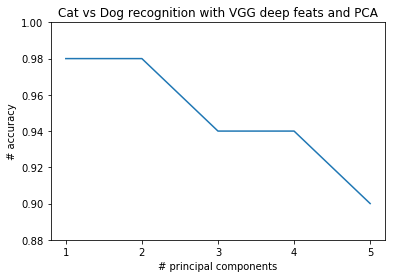

In [28]:
plot(ncs, pca_res);
xlabel('# principal components'); ylabel('# accuracy');
ylim([0.88,1]); xticks(ncs);
title('Cat vs Dog recognition with VGG deep feats and PCA');

OMG!!##!? WTF????!!&%$!

Apply the PCA transform for visualization

In [29]:
pca_vgg_feats = decomposition.PCA(n_components=2).fit_transform(vgg_feats)

Make a scatterplot of the first 2 components

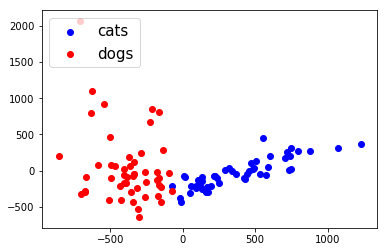

In [30]:
scatter(pca_vgg_feats[labels==0,0], pca_vgg_feats[labels==0,1], c='b');
scatter(pca_vgg_feats[labels==1,0], pca_vgg_feats[labels==1,1], c='r');
legend(['cats','dogs'], fontsize=15, loc='upper left');

Whooooohoooooooo!!!

## Resources

 1. [Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)